In [7]:
import tensorflow as tf
from util import *
from util.parser import *
from util.img_kit import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5) # set default size of plots


In [8]:
""" Load data """
img_folder = "data/moving-box/frames/square"
# img_folder = "data/moving-box/frames/moving-two-box-uniform"
# img_folder = "data/kid-conversation"
# img_folder = "data/kid-swing"
imgs = [p[2] for p in walk(img_folder)][0]
imgs = list(filter(lambda x: not x.startswith("."), imgs))
prefix, postfix = imgs[0].split("-")[0], imgs[0].split(".")[1]
print("Total Images: {}".format(len(imgs)))
print("From:         {}".format(imgs[0]))
print("To:           {}".format(imgs[-1]))

Total Images: 131
From:         square-001.jpeg
To:           square-131.jpeg


In [9]:
gap = 15
base_index = parse_img_index(imgs[0])
to = parse_img_index(imgs[-1]) - (len(imgs)-1)%(gap + 1)
num_intervals = (to-base_index)//(gap + 1)

print("Select Range:  {} -> {} | {} Intervals".format(base_index, to, num_intervals))

Select Range:  1 -> 129 | 8 Intervals


In [10]:
def index_to_img(i):
    return "{}/{}-{}.{}".format(img_folder, prefix, "%03d"%(base_index + i), postfix)

In [11]:
x_index = [i*gap for i in range(num_intervals + 1)]
mid_index = [x + (gap+1)//2 for x in x_index[:-1]]
X = np.concatenate([misc.imread(index_to_img(i))[np.newaxis, ...] for i in x_index], axis=0)    # training images
y = np.concatenate([misc.imread(index_to_img(i))[np.newaxis, ...] for i in mid_index], axis=0)
#y = [misc.imread(index_to_img(i)) for i in mid_index]  # ground truth of images in betwen
print("Image shape: {}".format(X[0].shape))
print(X.shape)
print(y.shape)

Image shape: (256, 256, 3)
(9, 256, 256, 3)
(8, 256, 256, 3)


In [12]:
X_train = X.astype('float32')
y_train = y.astype('float32')

## Parameter

In [13]:
batch_size = 8

In [14]:
def sample():
    """
    Select a batch size of data-point from X and y
    """
    start = np.random.choice(list(range(num_intervals)), size = batch_size)
    start_x = X_train[start,:,:,:]
    end_x = X_train[start + 1,:,:,:]
    batch_x = np.concatenate([start_x,end_x], axis = 3)
    batch_y = y_train[start,:,:,:]
    return((batch_x, batch_y))

In [15]:
sample()[0].shape

(8, 256, 256, 6)

In [16]:
# conv_layer: conv - BN - ReLu - max_pool
def conv_layer(X, scope, conv_size, conv_stride, bias_size):
    with tf.variable_scope(scope):
        W = tf.get_variable("Weight", shape=conv_size)
        b = tf.get_variable("Bias", shape=bias_size)
        a = tf.nn.conv2d(X, W, strides=conv_stride, padding='SAME') + b
        h = tf.nn.relu(a)
        return h
# dense_layer
def dense_layer(X, scope, weight_size, bias_size):
    with tf.variable_scope(scope):
        W = tf.get_variable("Weight", shape=weight_size)
        b = tf.get_variable("Bias", shape=bias_size)
        return tf.matmul(X, W) + b

In [17]:
tf.reset_default_graph()
def my_model(X,y):
    conv1 = conv_layer(X, 'conv1', [3,3,6,48],[1,1,1,1], [48])  # (N, 256, 256, 48)
    conv2 = conv_layer(conv1, 'conv2', [3,3,48,12],[1,1,1,1], [12]) # (N, 8, 8, 64)
    conv3 = conv_layer(conv2, 'conv3', [3,3,12,3],[1,1,1,1], [3]) # (N, 4, 4, 64)
    y_out = conv3
    return y_out

X = tf.placeholder(tf.float32, [None, 256, 256, 6])
y = tf.placeholder(tf.float32, [None, 256, 256, 3])

learning_rate = 1e-3
y_out = my_model(X,y)

mean_loss = tf.reduce_mean(tf.nn.l2_loss(y_out - y))
optimizer = tf.train.AdamOptimizer(learning_rate)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

pass

In [ ]:
epochs = 60
sess =  tf.Session()
sess.run(tf.global_variables_initializer())
variables = [mean_loss,train_step]
for e in range(epochs):
    sampled = sample()
    feed_dict = {X: sampled[0], y: sampled[1]}
    loss, _ = sess.run(variables,feed_dict=feed_dict)
    print('batch : {0}  loss: {1:.3e}'.format(e, loss))


batch : 0  loss: 5.049e+10
batch : 1  loss: 3.976e+10
batch : 2  loss: 3.526e+10
batch : 3  loss: 3.392e+10
batch : 4  loss: 3.462e+10
batch : 5  loss: 3.551e+10
batch : 6  loss: 3.531e+10
batch : 7  loss: 3.465e+10


In [19]:
return_variables = [mean_loss, y_out]
print(mean_loss)
print(y_out)
sampled = sample()
feed_dict = {X: sampled[0], y: sampled[1]}
result = sess.run(return_variables, feed_dict=feed_dict)

Tensor("Mean:0", shape=(), dtype=float32)
Tensor("conv3/Relu:0", shape=(?, 256, 256, 3), dtype=float32)


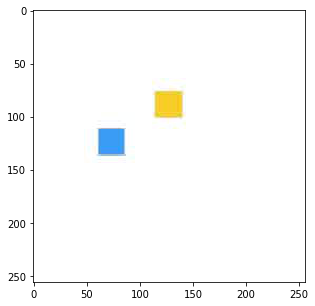

In [20]:
plt.imshow(sampled[0][3,:,:,:3].astype('uint8'))

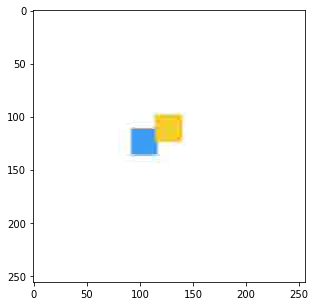

In [21]:
plt.imshow(sampled[0][3,:,:,3:].astype('uint8'))

In [22]:
test_ind = 3

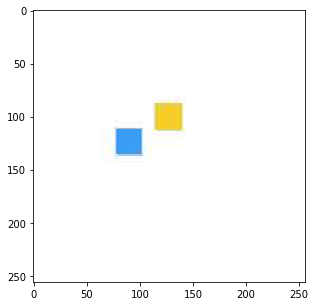

In [23]:
plt.imshow(sampled[1][test_ind,:,:,:].astype('uint8'))

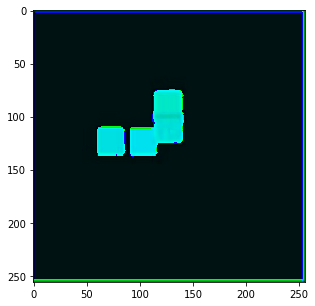

In [28]:
y_pred = result[1]
plt.imshow(y_pred[test_ind,:,:,:].astype('uint8'))

In [27]:
y_pred[test_ind,:,:,:].astype('uint8')

array([[[  0, 155, 114],
        [  0, 178, 127],
        [  0, 181, 114],
        ..., 
        [  0, 166, 106],
        [  0, 134, 101],
        [  0, 102,   0]],

       [[  0, 227, 196],
        [  0,   3, 209],
        [  0,  24, 195],
        ..., 
        [  0, 254, 162],
        [  0, 211, 173],
        [  0, 140,   0]],

       [[  0, 198, 225],
        [  0,  10,  13],
        [  0,  12, 247],
        ..., 
        [  0,   2, 211],
        [  0, 211, 221],
        [  0, 143,  12]],

       ..., 
       [[  0, 163, 253],
        [  0, 225,  65],
        [  0, 251,  51],
        ..., 
        [  0, 232,   3],
        [  0, 192, 245],
        [  0, 145,  44]],

       [[  0, 128, 226],
        [  0, 192,  25],
        [  0, 203,  34],
        ..., 
        [  0, 185, 246],
        [  0, 141, 229],
        [  0, 117,  59]],

       [[  0,  73, 182],
        [  0, 100, 231],
        [  0, 109, 234],
        ..., 
        [  0, 107, 207],
        [  0,  75, 163],
        [  0,  46,